In [1]:
using CSV, DataFrames, Dates
using PyCall
using DelimitedFiles, DataStructures
using CurveFit
using Plots; gr()

include("./src/cubes.jl")
include("./src/network.jl")
include("./src/motifs_discovery.jl")
include("./src/motifs_analysis.jl")

volume_tetrahedrons (generic function with 1 method)

In [2]:
# Read data
path = "./data/"
region = "california"
filepath = path * region * ".csv"

df_full = CSV.read(filepath, DataFrame);

# Filters
if (region == "vrancea") || (region == "romania")
    filepath = path * "romania" * ".csv"
    df_full = CSV.read(filepath, DataFrame);
    df = df_full[df_full.Datetime .> DateTime(1976,1,1,0,0,0),:];

    df = df[(df.Latitude .>= 45.20) .& (df.Latitude .<= 46.0) .& 
            (df.Longitude .>= 26.0) .& (df.Longitude .<= 27.0) .&
            (df.Depth .>= 50.0) .& (df.Depth .<= 200.0), :];# .&
            # (df.Magnitude .> 1.0) .& (df.Magnitude .<= 4), :];

elseif region == "california"
    df = df_full[df_full.Datetime .> DateTime(1988,1,1,0,0,0),:];
    df[findall(df.Depth .< 0.001),:Depth] .= 0.0;
    println("california chosen; start year processed")
    
elseif region == "italy"
    # df = df_full[df_full.Datetime .> DateTime(1988,1,1,0,0,0),:];
    df = select(df_full, Not(:Event_Type))

elseif region == "japan"
    df = df_full[df_full.Datetime .> DateTime(1988,1,1,0,0,0),:];
end

california chosen; start year processed


In [3]:
side = 5
minimum_magnitude = 0.0

df_filtered = df[df.Magnitude .> minimum_magnitude,:] 

# Split into cubes
df_filtered, df_filtered_cubes = region_cube_split(df_filtered,side=side,energyRelease=true);

# Create network
MG = create_network(df_filtered, df_filtered_cubes; edgeWeight=true)


{17285, 346868} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

### Connectivity analysis 

In [4]:
connectivity = degree(MG);

c = counter(connectivity)
Plots.scatter(collect(keys(c)),collect(values(c)),xscale=:log10,yscale=:log10)

UndefVarError: UndefVarError: b not defined

#### Degrees with self-loops and edge weights

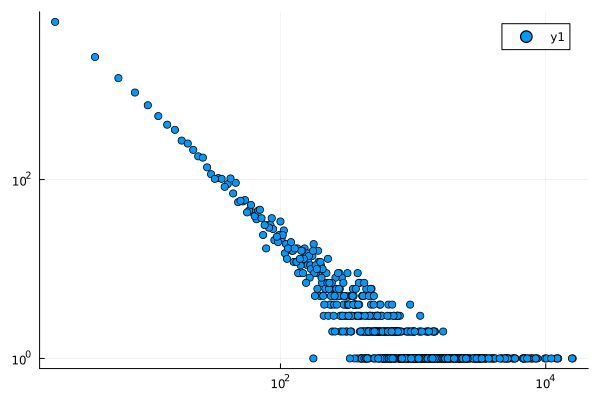

In [5]:
degrees=[]
for i=1:nv(MG)
    push!(degrees,get_prop(MG,i,:degree))
end

d = counter(degrees)
Plots.scatter(collect(keys(d)),collect(values(d)),xscale=:log10,yscale=:log10)

In [6]:
# for i=1:nv(MG)
#     # push!(degrees,get_prop(MG,i,:degree))
#     if isodd(get_prop(MG,i,:degree))
#         println(i)

#     end
# end

## Method 1: Simple CurveFit using Least Squares

In [7]:
# include("./src/histogram_fit.jl")
function power_law(x,b,a)
    return b*x .^(a)
end

power_law (generic function with 1 method)

In [8]:
x, y = collect(keys(d)),collect(values(d))

(Any[1438, 3174, 420, 3006, 638, 422, 242, 694, 224, 8660  …  1368, 128, 1318, 70, 350, 38, 326, 546, 298, 1402], [1, 1, 2, 1, 1, 2, 4, 2, 7, 1  …  1, 17, 2, 46, 5, 83, 3, 1, 7, 1])

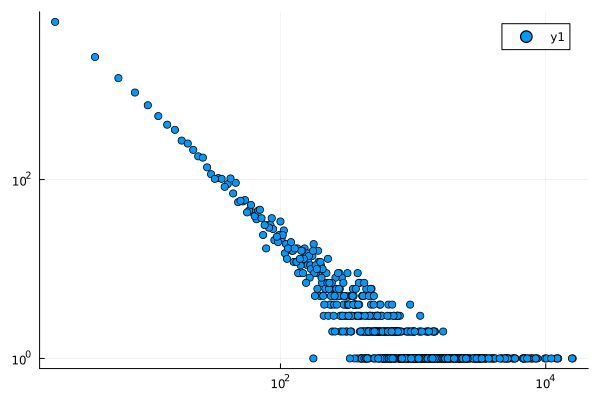

In [9]:
scatter(x,y,xscale=:log10,yscale=:log10)

In [14]:
parameters = power_fit(x, y)
a = round(parameters[2],digits=4)

-0.9203

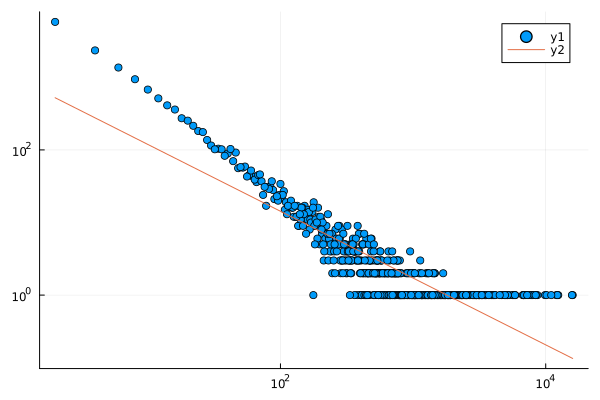

In [15]:
scatter(x, y,xscale=:log10,yscale=:log10)
plot!(x,power_law(x,parameters[1],parameters[2]))

In [49]:
# include("./src/histogram_fit.jl")
function power_law(x,a, b)
    return b*x .^(a)
end

power_law (generic function with 1 method)

In [40]:
using PyCall

wrap = pyeval("""lambda f: lambda a, b, c: f(a, b, c)""")
@pyimport scipy.optimize as sopt
pars, cov = sopt.curve_fit(wrap((x, a, b)->b.*x.^a), x, y)

# so = pyimport("scipy.optimize")
# f = PyCall.jlfun2pyfun((x, a, b)->b.*x.^a)
# so.curve_fit(f, x, y)

([-1.3482851927820056, 14834.548797186078], [3.3990582484205234e-6 -0.046507339234850245; -0.046507339234850245 830.6054550843354])

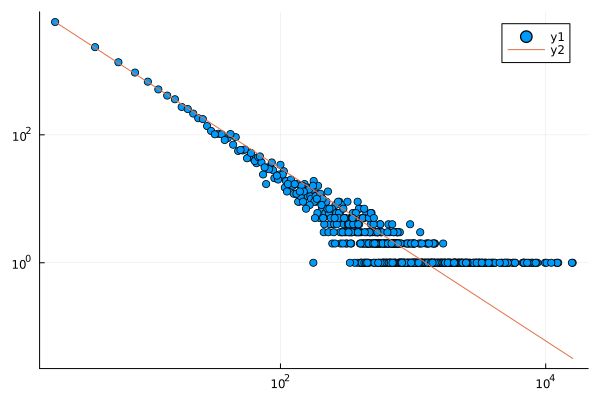

In [52]:
scatter(x,y,xscale=:log10,yscale=:log10)
plot!(x,power_law(x,pars[1],pars[2]),xscale=:log10,yscale=:log10)

In [55]:
yy = power_law(x,pars[1],pars[2])

629-element Vector{Float64}:
   0.8198129854631974
   0.28190941285613025
   4.309095966944467
   0.30335649942474624
   2.452314420569161
   4.2815836905497715
   9.061735493033652
   2.189331068442331
  10.057029846774887
   0.07284123011296205
   ⋮
  21.38722022170304
   0.9220162835480821
  48.25651724277149
   5.509917140421403
 109.97032546349854
   6.0637357228541084
   3.025227444040236
   6.844239350722777
   0.8483217252728964

In [54]:
x

629-element Vector{Any}:
 1438
 3174
  420
 3006
  638
  422
  242
  694
  224
 8660
    ⋮
  128
 1318
   70
  350
   38
  326
  546
  298
 1402

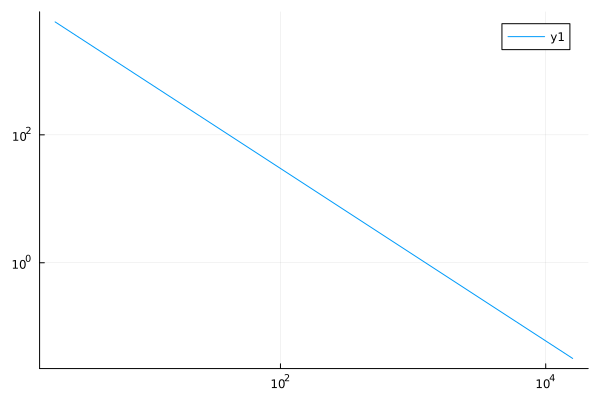

In [57]:
plot(x,yy,xscale=:log10,yscale=:log10)

In [48]:
x

629-element Vector{Any}:
 1438
 3174
  420
 3006
  638
  422
  242
  694
  224
 8660
    ⋮
  128
 1318
   70
  350
   38
  326
  546
  298
 1402

In [47]:
scatter(x,y)
plot!(x,power_law(x,*pars))

ErrorException: syntax: "*" is not a unary operator

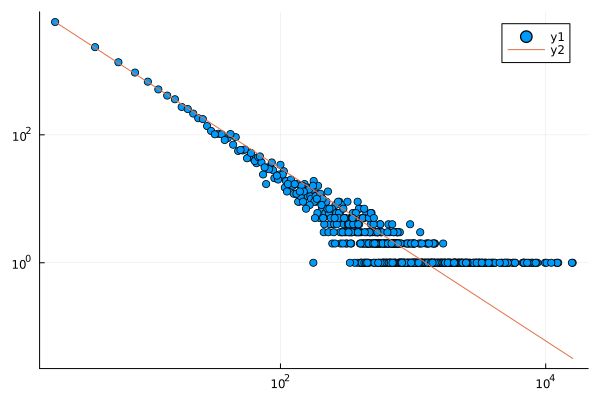

In [44]:
plot!(x,power_law(x,pars[1],pars[2]))

In [41]:
pars[1]

-1.3482851927820056

In [42]:
pars[2]

14834.548797186078

In [19]:
so.curve_fit(f=power_law, xdata=x, ydata=y,maxfev=5000)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/gabipana/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('callable <PyCall.jlwrap power_law> is not supported by signature')
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py", line 707, in curve_fit
    sig = _getfullargspec(f)
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/_lib/_util.py", line 370, in getfullargspec_no_self
    sig = inspect.signature(func)
  File "/usr/lib/python3.8/inspect.py", line 3105, in signature
    return Signature.from_callable(obj, follow_wrapped=follow_wrapped)
  File "/usr/lib/python3.8/inspect.py", line 2854, in from_callable
    return _signature_from_callable(obj, sigcls=cls,
  File "/usr/lib/python3.8/inspect.py", line 2417, in _signature_from_callable
    raise ValueError('callable {!r} is not supported by signature'.format(obj))


In [16]:
using SciPy

power_law (generic function with 1 method)

In [17]:
pars, cov = SciPy.optimize.curve_fit(f=power_law, xdata=x, ydata=y,maxfev=5000 )

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/gabipana/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('callable <PyCall.jlwrap power_law> is not supported by signature')
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py", line 707, in curve_fit
    sig = _getfullargspec(f)
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/_lib/_util.py", line 370, in getfullargspec_no_self
    sig = inspect.signature(func)
  File "/usr/lib/python3.8/inspect.py", line 3105, in signature
    return Signature.from_callable(obj, follow_wrapped=follow_wrapped)
  File "/usr/lib/python3.8/inspect.py", line 2854, in from_callable
    return _signature_from_callable(obj, sigcls=cls,
  File "/usr/lib/python3.8/inspect.py", line 2417, in _signature_from_callable
    raise ValueError('callable {!r} is not supported by signature'.format(obj))


In [18]:
@pyimport scipy.optimize as scp

In [30]:
py"""

from scipy.optimize import curve_fit


def power_law(x,b,a):
    return b*x ^(a)

def fit_data_powerlaw(f,x,y):f, xdata=x, ydata=y,maxfev=5000
    pars, cov = curve_fit()
    return pars

"""

In [32]:
const scipy_opt = PyNULL()

function __init__()
    copy!(scipy_opt, pyimport_conda("scipy.optimize", "scipy"))
end

__init__ (generic function with 1 method)

In [33]:
scipy_opt.curve_fit(f, xdata=x, ydata=y,maxfev=5000)

ArgumentError: ArgumentError: ref of NULL PyObject

In [31]:
pars = py"fit_data_powerlaw"(py"power_law",x,y)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/gabipana/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError("ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''")
  File "/home/gabipana/.julia/packages/PyCall/twYvK/src/pyeval.jl", line 9, in fit_data_powerlaw
    if m === Main
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py", line 789, in curve_fit
    res = leastsq(func, p0, Dfun=jac, full_output=1, **kwargs)
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py", line 410, in leastsq
    shape, dtype = _check_func('leastsq', 'func', func, x0, args, n)
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py", line 24, in _check_func
    res = atleast_1d(thefunc(*((x0[:numinputs],) + args)))
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py", line 485, in func_wrapped
    return func(xdata, *params) - ydata
  File "/home/gabipana/.julia/packages/PyCall/twYvK/src/pyeval.jl", line 6, in power_law


In [19]:
pars, cov = scp.curve_fit(f=power_law,xdata=x,ydata=y,maxfev=5000)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/gabipana/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('callable <PyCall.jlwrap power_law> is not supported by signature')
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py", line 707, in curve_fit
    sig = _getfullargspec(f)
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/_lib/_util.py", line 370, in getfullargspec_no_self
    sig = inspect.signature(func)
  File "/usr/lib/python3.8/inspect.py", line 3105, in signature
    return Signature.from_callable(obj, follow_wrapped=follow_wrapped)
  File "/usr/lib/python3.8/inspect.py", line 2854, in from_callable
    return _signature_from_callable(obj, sigcls=cls,
  File "/usr/lib/python3.8/inspect.py", line 2417, in _signature_from_callable
    raise ValueError('callable {!r} is not supported by signature'.format(obj))


### Method 2 : MLE using python powerlaw package

In [90]:
using PyCall
# using PyPlot
# @pyimport matplotlib.pyplot as plt
# function makeplot()    
#     pyplt.plot(1:10,(1:10).^2)
# end

@pyimport powerlaw as pwlaw

makeplot (generic function with 1 method)

In [113]:
fit = powerlaw.Fit(degrees)
fig1 = fit.plot_ccdf(linewidth=3)
fit.power_law.plot_ccdf(ax=fig1)
fit.lognormal.plot_ccdf(ax=fig1)
display(gcf())

Calculating best minimal value for power law fit


PyObject <powerlaw.Fit object at 0x7f755a5fa100>

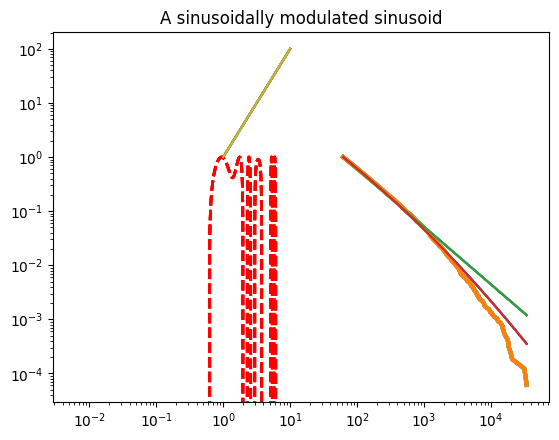

In [29]:
powerlaw = pyimport("powerlaw")

PyObject <module 'powerlaw' from '/home/gabipana/.local/lib/python3.8/site-packages/powerlaw.py'>

In [71]:
py"""
import powerlaw as powerlaw
def fit_data_powerlaw(data):
    results = powerlaw.Fit(data, discrete=True)
    print(results.power_law.alpha)
    print(results.power_law.xmin)
    # R, p = results.distribution_compare('power_law', 'lognormal')
    return results.power_law.alpha, results.power_law.xmin

def plot_pdf(fit_data):
    pdf = powerlaw.pdf(fit_data)
    return pdf



def fit_powerlaw(data):
    fit = powerlaw.Fit(data)
    fig1 = fit.plot_ccdf(linewidth=3)
    fit.power_law.plot_ccdf(ax=fig1)
    fit.lognormal.plot_ccdf(ax=fig1)
    return fig1
"""

In [72]:
fig = py"fit_powerlaw"(degrees)

Calculating best minimal value for power law fit


PyObject <AxesSubplot:>

In [76]:
fig.plot()

Any[]

In [60]:
py"""
fig1 = fit.plot_ccdf(linewidth=3)
fit.power_law.plot_ccdf(ax=fig1)
fit.lognormal.plot_ccdf(ax=fig1)
"""

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/gabipana/.julia/packages/PyCall/twYvK/src/pyeval.jl:38 =# @pysym(:PyEval_EvalCode), PyPtr, (PyPtr, PyPtr, PyPtr), o, globals, locals))))) <class 'NameError'>
NameError("name 'fit' is not defined")
  File "/home/gabipana/.julia/packages/PyCall/twYvK/src/pyeval.jl", line 1, in <module>
    const Py_single_input = 256  # from Python.h


In [31]:
a,xmin = py"fit_data_powerlaw"(degrees)

Calculating best minimal value for power law fit


(2.0572820608191296, 62.0)

In [32]:
pdf = py"plot_pdf"(degrees)

([2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 16.0, 20.0  …  4223.0, 5326.0, 6716.0, 8470.0, 10682.0, 13471.0, 16988.0, 21424.0, 27017.0, 34072.0], [0.4219843450313618, 0.0, 0.1603953916334042, 0.0, 0.04435520449950754, 0.028081423980094344, 0.019887836296718676, 0.012816857601990566, 0.008051844124202996, 0.006276890778083044  …  1.6310471666812768e-7, 8.811929594985387e-8, 5.593990413392162e-8, 2.2165469425926756e-8, 1.1717369913524872e-8, 5.8082695967902966e-9, 6.448384835833776e-9, 3.651772746945026e-9, 0.0, 9.184557848588595e-10])

In [54]:
fit = py"powerlaw.Fit"(degrees)

2.0572820608191296
62.0
Calculating best minimal value for power law fit


PyObject <powerlaw.Fit object at 0x7f768761deb0>

In [55]:
fit.discrete

false

In [58]:
py"fit.plot_ccdf"

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/gabipana/.julia/packages/PyCall/twYvK/src/pyeval.jl:38 =# @pysym(:PyEval_EvalCode), PyPtr, (PyPtr, PyPtr, PyPtr), o, globals, locals))))) <class 'NameError'>
NameError("name 'fit' is not defined")
  File "/home/gabipana/.julia/packages/PyCall/twYvK/src/pyeval.jl", line 1, in <module>
    const Py_single_input = 256  # from Python.h


In [33]:
function power_law(x,b,a)
    return b*x .^(-a)
end

power_law (generic function with 1 method)

In [43]:
function power_law(x,a,b)
    return b*x .^(-a)
end

power_law (generic function with 2 methods)

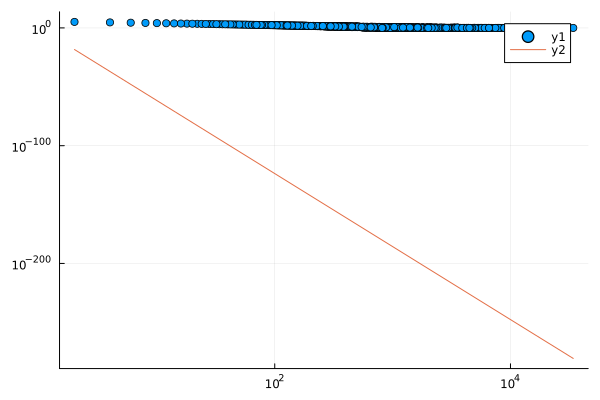

In [52]:
scatter(x,y,xscale=:log10,yscale=:log10)
plot!(x,power_law(x,a,xmin))

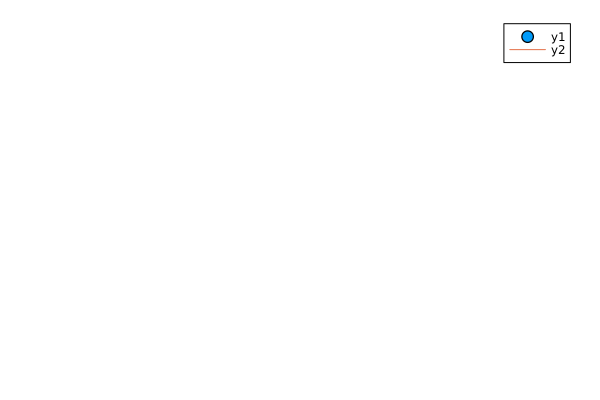

┌ Warning: No strict ticks found
└ @ PlotUtils /home/gabipana/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/gabipana/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/gabipana/.julia/packages/Plots/nuwp4/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /home/gabipana/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/gabipana/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/gabipana/.julia/packages/Plots/nuwp4/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /home/gabipana/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/gabipana/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warnin

In [35]:
scatter(pdf[1],pdf[2],xscale=:log10, yscale=:log10)
plot!(pdf[1],power_law(pdf[1],xmin,a))

In [ ]:
scatter(pdf,xscale=:log10, yscale=:log10)
plot!(pdf,power_law(pdf,xmin,a))

MethodError: MethodError: no method matching ^(::Vector{Float64}, ::Float64)
Closest candidates are:
  ^(!Matched::Symmetric{var"#s886", S} where {var"#s886"<:Real, S<:(AbstractMatrix{<:var"#s886"})}, ::Real) at /opt/julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/symmetric.jl:683
  ^(!Matched::Symmetric{var"#s886", S} where {var"#s886"<:Complex, S<:(AbstractMatrix{<:var"#s886"})}, ::Real) at /opt/julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/symmetric.jl:692
  ^(!Matched::UniformScaling, ::Number) at /opt/julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/uniformscaling.jl:317
  ...